# Traffic Sign Classification for German Data Set 


# Import the libraries

In [1]:
# Importing Python libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix
import csv
import skimage.morphology as morp
import cv2
from sklearn.utils import shuffle
from skimage.filters import rank

In [2]:
# Load Dataset from Pickle Data
def GetData():
    # Open the pickle files
    with open("./pickledata/train.p",mode = 'rb') as f:
        train = pickle.load(f)
    with open("./pickledata/valid.p",mode = 'rb') as f:
        valid = pickle.load(f)
    with open("./pickledata/test.p",mode = 'rb') as f:
        test = pickle.load(f)
    
    data = {
        "X_train" : train['features'],
        "X_validation" : valid['features'],
        "X_test" : test['features'],
        "Y_train" : train['labels'],
        "Y_validation" : valid['labels'],
        "Y_test" : test['labels']
    }
    return data


In [3]:
data = GetData()
X_train = data["X_train"]
X_valid = data["X_validation"]
X_test = data["X_test"]
Y_train = data["Y_train"]
Y_valid = data["Y_validation"]
Y_test = data["Y_test"]

# Shuffle Data 
X_train, Y_train = shuffle(X_train,Y_train)

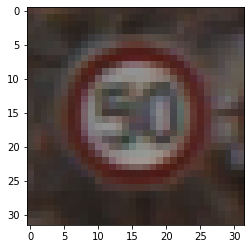

[ 2  1  1 ... 38 26 14]


In [4]:
plt.imshow(X_train[0])
plt.show()
print(Y_train)

In [5]:
# Preprocessing methods 
# we can use the combination of different combination of preprocessing methods to get better results
def GrayScale(x_image):
    return cv2.cvtColor(x_image, cv2.COLOR_RGB2GRAY)

def LocalHistogramEqualization(x_image):
    kernel = morp.disk(30)
    img_local = rank.equalize(x_image, selem=kernel)
    return img_local

def Normalization(x_image):
    normalized_image = np.divide(x_image, 255)
    return normalized_image

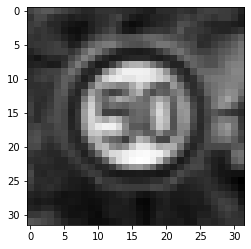

In [6]:
# Sample images after greyscaling
grayscale_images = []
for i in range(len(X_train)):
    grayscale_images.append(GrayScale(X_train[i]))

plt.imshow(grayscale_images[0],cmap='gray')
plt.show()



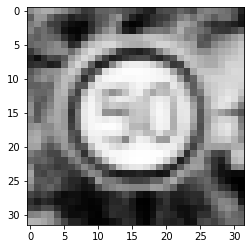

In [7]:
equalized_images = []
for i in range(len(grayscale_images)):
    equalized_images.append(LocalHistogramEqualization(grayscale_images[i]))
plt.imshow(equalized_images[0],cmap="gray")
plt.show()

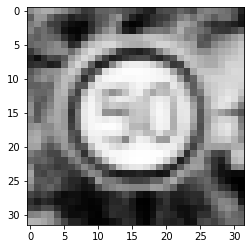

In [8]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = Normalization(img)

normalized_images = normalized_images[..., None]

normal = Normalization(equalized_images[0])
plt.imshow(normal,cmap="gray")
plt.show()
#print(normalized_images.shape)

In [9]:
# Preprocess the Images 
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import cv2
def Preprocessing(data):
    
    gray = []
    for i in range(len(data)):
        gray.append(GrayScale(data[i]))
    
    
    
    
    equalized_images = []
    for i in range(len(gray)):
        equalized_images.append(LocalHistogramEqualization(gray[i]))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = Normalization(img)
    normalized_images = normalized_images[..., None]
    return normalized_images



In [12]:
# Model Training and Evaluation
x = tf.placeholder(tf.float32, (None,32,32,1))
y = tf.placeholder(tf.int32,(None))
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers
X_valid_preprocessed = Preprocessing(X_valid)
X_testing_preprocessed = Preprocessing(X_test)

In [13]:
def ConvolutionOperation(x_input,filter_width,filter_height,channels,outputs):
    weight = tf.Variable(tf.truncated_normal(shape=(filter_width,filter_height,channels,outputs),stddev = 0.1))
    bias = tf.Variable(tf.zeros(outputs))
    conv = tf.nn.conv2d(x_input, weight, strides=[1, 1, 1, 1], padding='VALID') + bias
    return conv

In [40]:
n_out = 43

# Layer 1 
#conv1_weight = ConvolutionOperation(x_input):
w1 = tf.Variable(tf.truncated_normal(shape=(5,5,1,6),stddev = 0.1))
b1 = tf.Variable(tf.zeros(6))
l1 = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='VALID') + b1
l1 = tf.nn.relu(l1)
l1 = tf.nn.max_pool(l1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


# Layer 2 (Convolutional): Output = 10x10x16.
w2 = tf.Variable(tf.truncated_normal(shape=(5,5,6,16),stddev = 0.1))
b2 = tf.Variable(tf.zeros(16))
l2 = tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1], padding='VALID') + b2
l2 = tf.nn.relu(l2)
l2 = tf.nn.max_pool(l2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flattening: Input = 5x5x16. Output = 400.
array = flatten(l2)

# Layer 3 (Fully Connected): Input = 400. Output = 120.
w3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = 0, stddev = 0.1))
b3 = tf.Variable(tf.zeros(120))
l3 = tf.add((tf.matmul(array, w3)), b3)
l3 = tf.nn.relu(l3)

# Layer 4 (Fully Connected): Input = 120. Output = 84.
w4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = 0, stddev = 0.1))
b4 = tf.Variable(tf.zeros(84))
l4 = tf.add((tf.matmul(l3, w4)), b4)
l4 = tf.nn.relu(l4)

# Layer 5 (Fully Connected): Input = 84. Output = 43.
w5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = 0, stddev = 0.1))
b5 = tf.Variable(tf.zeros(43))
logits =  tf.add((tf.matmul(l4, w5)), b5)

# Training operation
one_hot_y = tf.one_hot(y, n_out)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_operation = optimizer.minimize(loss_operation)


In [45]:

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [46]:
def FindAccuracy(x_data, y_data, BATCH_SIZE=64):
    print("Print Accuracy")
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for i in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[i:i+BATCH_SIZE], y_data[i:i+BATCH_SIZE]
        accuracy = sess.run(acc, 
                            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [49]:
def FinalPrediction(x_data,BATCH_SIZE = 64):
    num_examples = len(x_data)
    y_pred = np.zeros(num_examples,dtype=np.int32)
    sess = tf.get_default_session()
    for offset in range(0,num_examples,BATCH_SIZE):
        batch_x = x_data[offset:offset + BATCH_SIZE]
        y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(logits, 1),feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
    return y_pred

In [50]:
epoch_x = []
epoch_y = []
BATCH_SIZE = 64
total_epochs = 20
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(Y_train)
    for i in range(20):
        normalized_images, Y_train = shuffle(normalized_images, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], Y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})            
        validation_accuracy = FindAccuracy(X_valid_preprocessed, Y_valid)
        print("**********Validation Accuracy***********")
        print("epoch {} : Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    Y_testing_output = FinalPrediction(X_testing_preprocessed)
    testing_acc = sum(Y_test == Y_testing_output)/len(Y_test)
    print("******************Testing Accuracy ***********")
    print("Accuracy : {:.1f}%".format(testing_acc*100))

Print Accuracy
**********Validation Accuracy***********
epoch 1 : Accuracy = 77.234%
Print Accuracy
**********Validation Accuracy***********
epoch 2 : Accuracy = 86.803%
Print Accuracy
**********Validation Accuracy***********
epoch 3 : Accuracy = 89.093%
Print Accuracy
**********Validation Accuracy***********
epoch 4 : Accuracy = 90.998%
Print Accuracy
**********Validation Accuracy***********
epoch 5 : Accuracy = 90.567%
Print Accuracy
**********Validation Accuracy***********
epoch 6 : Accuracy = 90.091%
Print Accuracy
**********Validation Accuracy***********
epoch 7 : Accuracy = 91.565%
Print Accuracy
**********Validation Accuracy***********
epoch 8 : Accuracy = 91.565%
Print Accuracy
**********Validation Accuracy***********
epoch 9 : Accuracy = 91.950%
Print Accuracy
**********Validation Accuracy***********
epoch 10 : Accuracy = 91.973%
Print Accuracy
**********Validation Accuracy***********
epoch 11 : Accuracy = 92.608%
Print Accuracy
**********Validation Accuracy***********
epoch 1

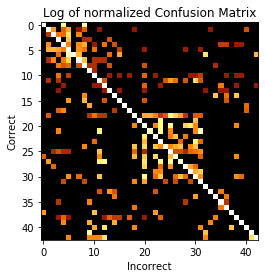

In [51]:
cm = confusion_matrix(Y_test, Y_testing_output)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.afmhot)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('Correct')
plt.xlabel('Incorrect')
plt.show()